# PUI2017 HW6

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import numpy as np
import os
import seaborn
import statsmodels.api as sm
import statsmodels.formula.api as smf

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

###### commented code to move files into PUIdata

In [2]:
#!mv 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv' $PUIDATA
#!mv 'mn_mappluto_16v2.zip' $PUIDATA
#unzip folder into 'Manhattan' folder in PUIDATA
#!unzip mn_mappluto_16v2.zip -d Manhattan

In [3]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")

In [4]:
# keep only a few columns
nrg = nrg[['BBL','Postcode','Site EUI(kBtu/ft2)','Weather Normalized Site EUI(kBtu/ft2)',
             'Source EUI(kBtu/ft2)','Weather Normalized Source EUI(kBtu/ft2)',
             'Reported Property Floor Area (Building(s)) (ft²)',
             'DOF Property Floor Area (Buildngs and Parking)(ft2)',
             'DOF Number of Buildings']]
nrg.head(2)

,BBL,Postcode,Site EUI(kBtu/ft2),Weather Normalized Site EUI(kBtu/ft2),Source EUI(kBtu/ft2),Weather Normalized Source EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
Record Number,,,,,,,,,
12086,1.000410e+09,NaN,NaN,Not Available,NaN,Not Available,918919,NaN,NaN
14354,4.021460e+09,11375.0,NaN,NaN,NaN,NaN,NaN,82730.0,1.0


In [5]:
bsize = bsize[['BBL','UnitsRes','UnitsTotal','YearBuilt']]
bsize.head(2)

,BBL,UnitsRes,UnitsTotal,YearBuilt
0,1.000010e+09,0,0,1900
1,1.000090e+09,0,0,1987


## exploratory analysis

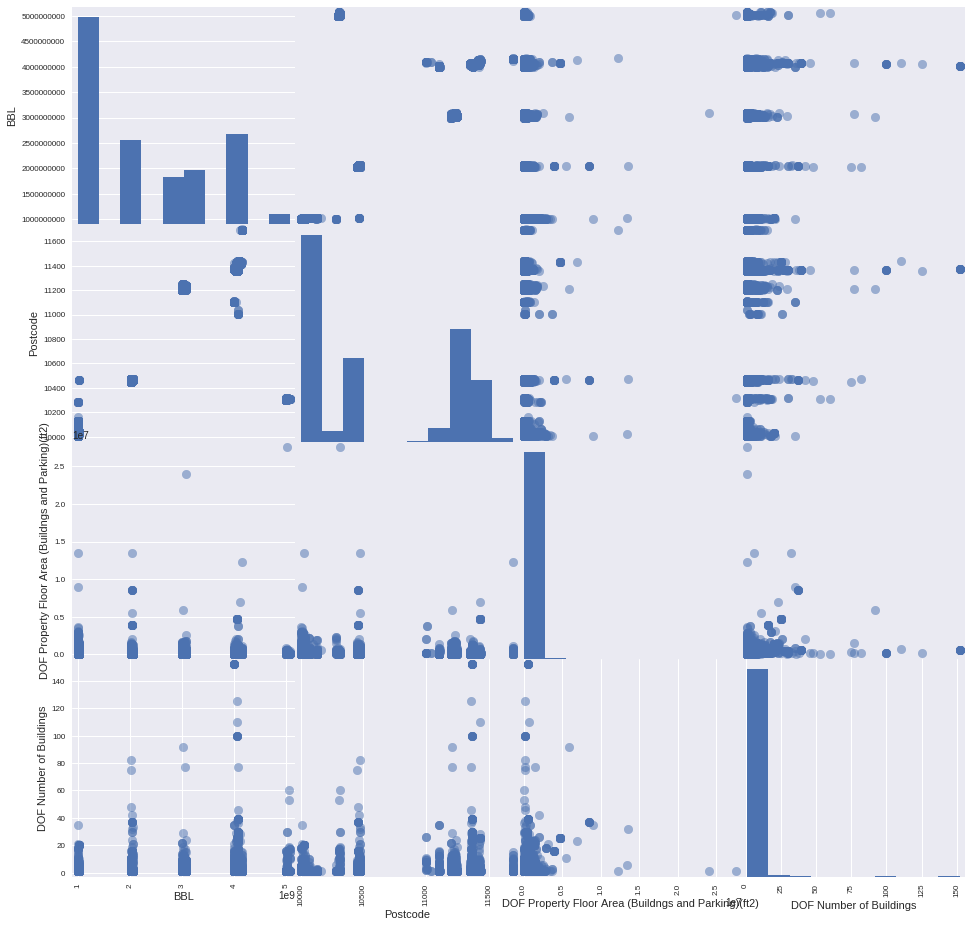

In [6]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

### Figure 1 show a scatter matrix of all numerical values in the LL84 Energy and Water data. The variables shown here are numerical in nature and can be plotted (BBL, postcode, etc.) but are of little interest. Most of the data of interest, including building energy usage, can't be plotted without cleaning the dataset first.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

In [7]:
nrg = nrg[['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]
nrg.head(2)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919
14354,4.021460e+09,NaN,NaN


In [8]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
print (nrg['Site EUI(kBtu/ft2)'].astype(float), '\n')

nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], 
                                                                        errors='coerce')
print (nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float), '\n')

bsize['BBL'] = pd.to_numeric(bsize['BBL'], errors='coerce')
print(bsize.BBL.astype(float))

Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
13804      NaN
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), dtype: float64 

Record Number
12086    91891

In [9]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

indx2 = np.isnan(nrg['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))

invalid entries changed to NaN 4623
invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [10]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [11]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


(5062, 6)

In [12]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt
2,1.013110e+09,125.4,330000.0,0,56,1977
10,1.010140e+09,154.9,841709.0,0,2,1999
15,1.007660e+09,122.3,59468.0,0,8,1912
16,1.008150e+09,117.0,364000.0,0,24,1954
18,1.005050e+09,82.1,235370.0,0,24,1926


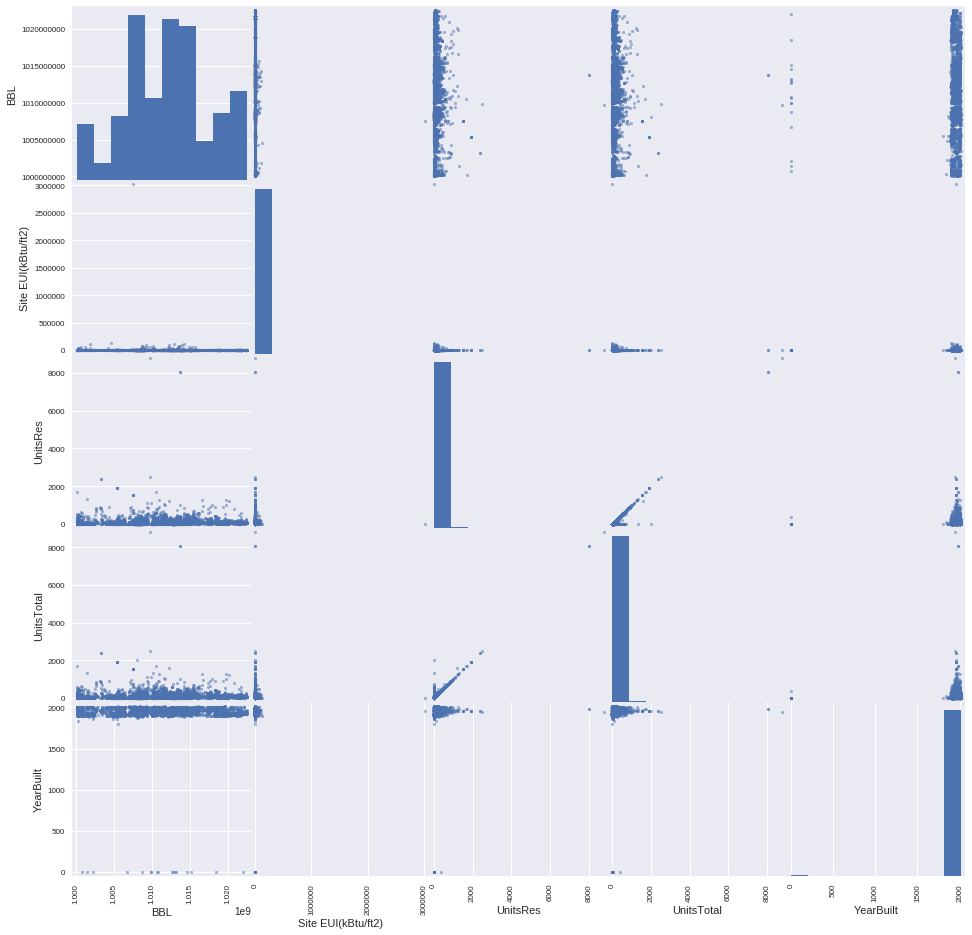

In [13]:
bblnrgdata2 = bblnrgdata.drop(['Reported Property Floor Area (Building(s)) (ft²)'], axis=1)

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata2, s=30, figsize=(16, 16));

### Figure 2 shows a scatter matrix of the final combined dataset, with data on both building energy usage and building size. It is difficult to visually see any potential relationships in the data due to the size of the plots, so it will be necessary to explore the individual plots of interest more closely.

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

In [14]:
bblnrgdata['total energy consumption (kBtu)'] = (bblnrgdata['Site EUI(kBtu/ft2)'] * 
                                                 bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'])

In [15]:
bblnrgdata.head(2)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,total energy consumption (kBtu)
2,1.013110e+09,125.4,330000.0,0,56,1977,41382000.0
10,1.010140e+09,154.9,841709.0,0,2,1999,130380724.1


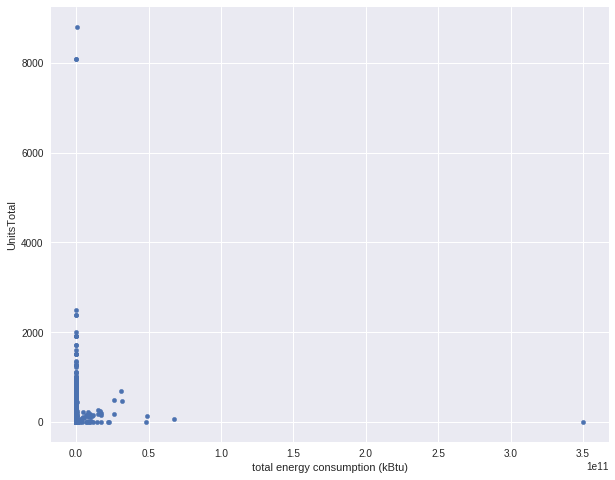

In [16]:
fig = pl.figure(figsize(10,8))
bblnrgdata.plot.scatter(x='total energy consumption (kBtu)', y='UnitsTotal', marker = 'o');

### Figure 3 shows a scatter plot of total number of units  vs total energy consumption for each reported building. Each point represents a building - the majority of the datapoints are clustered in the bottom left corner, with a few signficant outliers along both axes.

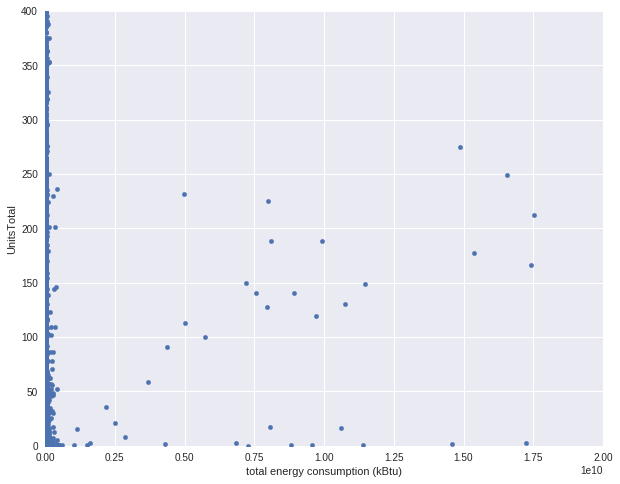

In [17]:
fig = pl.figure(figsize(10,8))
bblnrgdata.plot.scatter(x='total energy consumption (kBtu)', y='UnitsTotal', 
                        xlim=(0, 2e10), ylim=(0, 400));

### Figure 4 shows a zoomed in scatter plot of total number of units vs total energy consumption from Figure 3. Even in this zoomed-in view, the majority of the datapoints are clustered near 0 kBtu energy consumption, which is likely faulty/misreported data.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [18]:
#you may need to change the name of this column under some versions of pandas
#(ft²) may throw an error due to the funny character depending on encoding
bblnrgdata['Property Floor Area'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


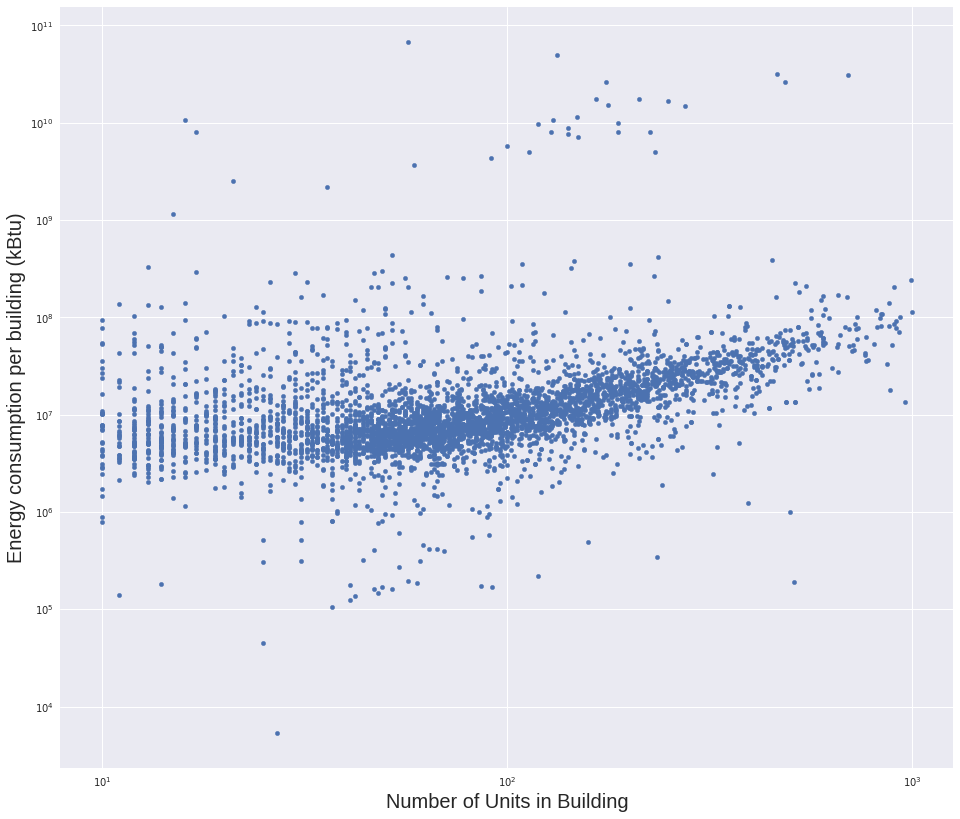

In [19]:
# I have the energy per sq foot in the data, I need the total energy though
bblnrgdata['nrg'] = bblnrgdata['total energy consumption (kBtu)']

bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

ax = bblnrgdataCut.plot(kind='scatter', y='nrg', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

### Figure 5 shows a loglog scatter plot of energy consumption vs number of units in building, with outliers and misreported data removed. There appears to be a roughly linear relationship, with building energy consumption increasing with the number of units.

### Fitting line to energy vs. number of units

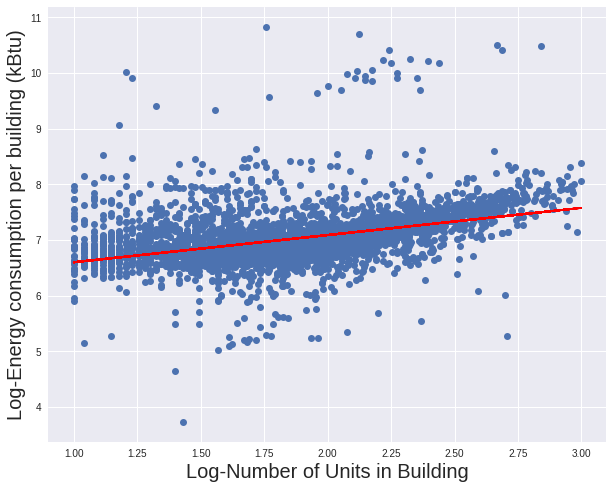

In [20]:
x1 = bblnrgdataCut['UnitsTotal']
y1 = bblnrgdataCut['nrg']
X1 = sm.add_constant(np.log10(x1))
linmodel1 = sm.OLS(np.log10(y1), X1, missing='drop').fit() # ignores entires 
                                                            # where x or y is NaN


pl.plot(np.log10(x1), np.log10(y1), 'o')
pl.plot(np.log10(x1),linmodel1.fittedvalues, color='r')
pl.xlabel("Log-Number of Units in Building", fontsize=20)
pl.ylabel("Log-Energy consumption per building (kBtu)", fontsize=20);

### Figure 6 shows the loglog scatter plot of energy consumption vs number of units in building from Figure 5, with an approximate regression line fit through the data.

In [21]:
linmodel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          2.05e-166
Time:                        23:49:03   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1110      0.033    187.012      0.000         6.047     6.175
UnitsTotal     0.4882      0.017     28.761      0.000         0.455     0.521
==============================================================================
Omnibus:                     2264.923   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44888.937
Skew:                           2.089   Prob(JB):                         0.00
Kurtosis:                      18.333   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fitting line to number of units vs. energy

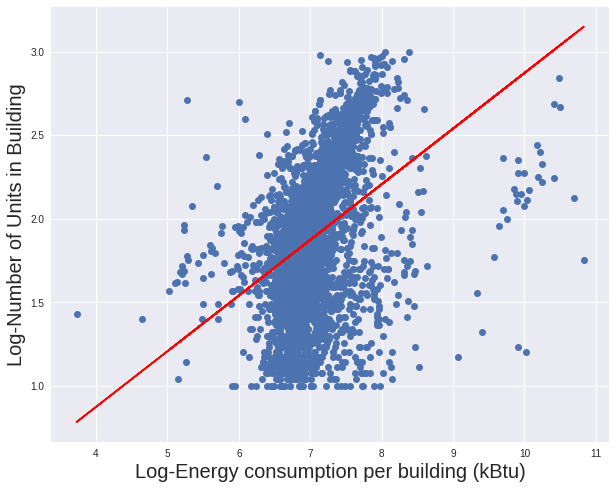

In [22]:
#fitting energy vs. units
x2 = bblnrgdataCut['nrg']
y2 = bblnrgdataCut['UnitsTotal']
X2 = sm.add_constant(np.log10(x2))
linmodel2 = sm.OLS(np.log10(y2), X2, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN
#ax = bblnrgdataCut.plot(kind='scatter', y='UnitsTotal', x='nrg', 
#                   marker='o',  figsize=(16, 14), loglog=True)
pl.plot(np.log10(x2), np.log10(y2), 'o')
pl.plot(np.log10(x2),linmodel2.fittedvalues, color='r')
pl.xlabel("Log-Energy consumption per building (kBtu)", fontsize=20)
pl.ylabel("Log-Number of Units in Building", fontsize=20);

### Figure 7 shows the loglog scatter plot of number of building units vs. energy consumption vs number of units in building, with an approximate regression line fit through the data.

In [23]:
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          2.05e-166
Time:                        23:49:03   Log-Likelihood:                -1746.4
No. Observations:                4266   AIC:                             3497.
Df Residuals:                    4264   BIC:                             3510.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4563      0.082     -5.596      0.000        -0.616    -0.296
nrg            0.3328      0.012     28.761      0.000         0.310     0.356
==============================================================================
Omnibus:                      149.498   Durbin-Watson:                   1.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.251
Skew:                          -0.464   Prob(JB):                     1.31e-36
Kurtosis:                       3.260   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Evaluating which line model is better

In [24]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [25]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Property Floor Area'])**2 +
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log

In [26]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
fit1 = chi2(np.log10(y1), linmodel1.fittedvalues, errorsInLogNrg)
fit2 = chi2(np.log10(y2), linmodel2.fittedvalues, errorsInLogUnits)
print("Chi square fit statistic for Energy vs. Units:",fit1,'\n',
      "Chi square fit statistic for Units vs. Energy:",fit2)

Chi square fit statistic for Energy vs. Units: 3.49306834927e+12 
 Chi square fit statistic for Units vs. Energy: 485793.290042


#### The error is equivalent to the Poisson statistics. The chi square statistics for both models is very large, much higher than the critical value and show that they are poor fits. We should expect the energy vs. units model to fit better, but the chi square statistic is much higher than the other model.

## Fit a second degree polynomial

In [28]:
#make smaller dataframe for fitting
df1 = bblnrgdataCut[['UnitsTotal','nrg']]
df1.head()

#take log of data
df_log = np.log10(df1)
df_log.head()

,UnitsTotal,nrg
2,1.748188,7.616811
16,1.380211,7.629287
18,1.380211,7.286094
19,1.792392,6.950549
20,1.929419,6.811909


In [29]:
quadmodel= smf.ols(formula='nrg ~ I(UnitsTotal**2) + UnitsTotal', data = df_log)

model2 = quadmodel.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     617.1
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          4.37e-236
Time:                        23:49:03   Log-Likelihood:                -2399.4
No. Observations:                4266   AIC:                             4805.
Df Residuals:                    4263   BIC:                             4824.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.0824      0.111     72.620      0.000         7.864     8.301
I(UnitsTotal ** 2)     0.5710      0.031     18.465      0.000         0.510     0.632
UnitsTotal            -1.6820      0.119    -14.175      0.000        -1.915    -1.449
==============================================================================
Omnibus:                     2411.825   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59289.371
Skew:                           2.208   Prob(JB):                         0.00
Kurtosis:                      20.722   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

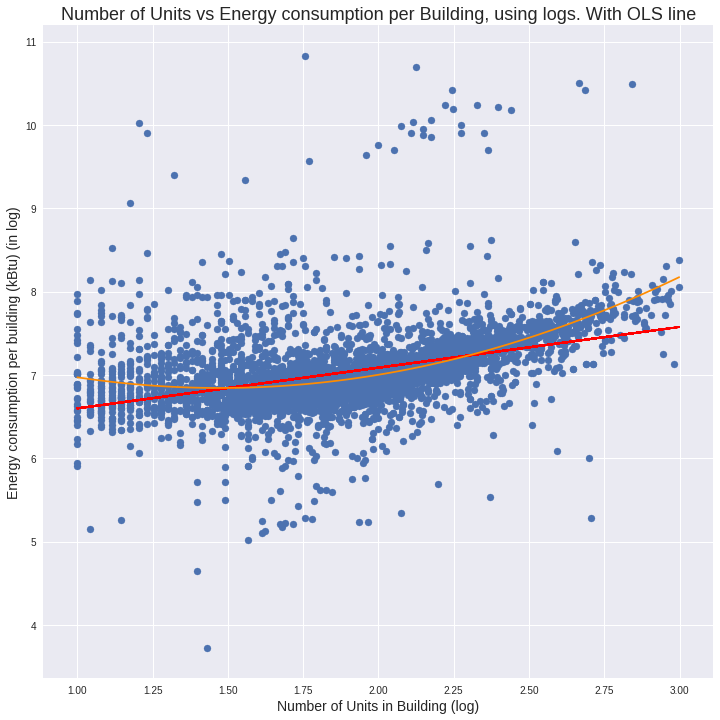

In [30]:
#plotting
pl.figure(figsize=[12,12])
pl.plot(np.log10(df1['UnitsTotal']), linmodel1.fittedvalues, color='red')
pl.scatter(x=np.log10(df1['UnitsTotal']), y=np.log10(df1['nrg']))

df_sorted = df_log.sort_values(by='UnitsTotal')
pl.plot(df_sorted['UnitsTotal'], model2.predict(df_sorted), color="DarkOrange")

pl.xlabel("Number of Units in Building (log)", fontsize=14)
pl.ylabel("Energy consumption per building (kBtu) (in log)", fontsize=14)

#pl.xlim(0,100)
#pl.ylim(0,100)


pl.title("Number of Units vs Energy consumption per Building, using logs. With OLS line", fontsize=18);

### Figure 8 shows the loglog scatter plot of energy consumption vs number of units in building, with both a simple linear regression fit and and second degree polynomial fit.

#### Null Hypothesis: The more complicated (polynomial) model is a better fit for our data. P-value = 0.05

In [31]:
model2.compare_lr_test(linmodel1)

(328.25131091974526, 2.3102405124986843e-73, 1.0)

#### This returns to us the likelihood ratio, p-value, and difference in degrees of freedom of the models.
The likelihood ratio of 328 is very high, while the p-value is extremely low. The high liklihood ratio (greater than the critical value of 3.84 from  the chi sq table and low p-value indicate that we can't reject our null hypothesis.